In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import numpy as np
import pandas as pd
import squidpy as sq
import os
from sklearn.preprocessing import LabelEncoder


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Load data

In [2]:
# scRNA= ad.read_h5ad("./GSE149457_RAW/chicken_hearts.h5ad")
# labels_dict= {'D4':1, 'D7':2, 'D10':3, 'D14':4}
# cell_type_key= 'celltypes.0.5'

# scRNA= ad.read_h5ad("./StereoSeq/stereo_seq_harmony.h5ad")
# labels_dict= {'s1':1, 's2':2, 's3':3, 's4':4, 's5':5}
# cell_type_key= 'Annotation'

scRNA= ad.read_h5ad("./datasets/h5ad_processed_datasets/stereo_seq.h5ad")
labels_dict= {'s1':1, 's2':2, 's3':3, 's4':4, 's5':5}
cell_type_key= 'Annotation'

/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## FM start

In [3]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP, GradModel, Graph_like_transformer
from torchcfm.utils import plot_trajectories, torch_wrapper
import pandas as pd

savedir = "models/"
os.makedirs(savedir, exist_ok=True)

In [4]:
# Assuming conditional_labels is a numpy array or pandas Series

params= {}  
params['batch_size']= 256
params['sigma']= 0.9
params['dim']= 3
params['learning_rate']= 1e-4
params['n_epochs']= 100
params['in_dim']= 3
params['out_dim']= 2
params['w']= 10
params['time_varying']= True
params['lambda_']= 0.3

use_cuda= False
device = torch.device("cuda" if use_cuda else "cpu")

# day_list= (scRNA.obs["day"]).values.tolist()
day_list= scRNA.obs['Annotation'].values.tolist()




In [5]:
def preprocess_data(scRNA):

    # Display the data matrix
    data_matrix = scRNA.X
    # data_matrix= scRNA.obsm["X_umap"]
    
    ind_list= list(scRNA.obs.index)
    day_list= list(scRNA.obs["day"])
    df_index= [ind_list[i].split("-")[0]+'_'+day_list[i] for i in range(len(ind_list))]

    # Convert to DataFrame for better readability
    data_df = pd.DataFrame(data_matrix.toarray() if hasattr(data_matrix, "toarray") else data_matrix,
                        index=df_index,
                        columns=scRNA.var_names)

    n_genes= 2000
    # Sum the expression values for each gene across all cells
    gene_sums = data_df.sum(axis=0)

    # Get the top n_genes genes based on expression sums
    top_genes = gene_sums.nlargest(n_genes).index

    # Filter the DataFrame to only include the top 100 expressed genes
    data_df = data_df[top_genes]

    # Display the DataFrame
    data_df['day']= [d.split('_')[-1] for d in data_df.index]

    all_times= data_df['day'].unique()


    # Remove the 'day' column from the DataFrame
    data_df = data_df.drop(columns=['day'])

    X_raw = [np.array(data_df[data_df.index.str.contains(d)]) for d in all_times]

    return X_raw, data_df



def process_data(scRNA, X_raw, cell_type_key):

    X_phate=[]
    X_phate_conditional=[]
    Spatial=[]

    centroids= []
    le = LabelEncoder()
    encoded_labels = le.fit_transform(scRNA.obs[cell_type_key].values)

    left_counter=0
    right_counter=X_raw[0].shape[0]
    for i in range(len(labels_dict)):
        X_phate.append(scRNA.obsm["X_umap"][left_counter:right_counter])
        X_phate_conditional.append(encoded_labels[left_counter:right_counter])
        Spatial.append(scRNA.obsm['spatial'][left_counter:right_counter])
        # cen= [(scRNA.obsm['spatial'][left_counter:right_counter])[:,0].mean(), (scRNA.obsm['spatial'][left_counter:right_counter])[:,1].mean()]
        # Spatial.append(scRNA.obsm['spatial'][left_counter:right_counter]-cen)
    

        if i<len(labels_dict)-1:
            left_counter=right_counter
            right_counter+=X_raw[i+1].shape[0]
    
    return X_phate, X_phate_conditional, Spatial

In [6]:
X_raw, data_df= preprocess_data(scRNA)
X_phate, X_phate_conditional, Spatial= process_data(scRNA, X_raw, cell_type_key)

n_times= len(X_phate)

In [7]:
import scprep


def plot_trajectories(traj, day_list, legend=True):
    n = 200
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    scprep.plot.scatter(
        scRNA.obsm["X_umap"][:, 0],
        scRNA.obsm["X_umap"][:, 1],
        c=day_list,
        ax=ax,
    )
    # ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    # ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(10):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="black")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    # plt.xticks([])
    # plt.yticks([])
    # plt.axis("off")



def plot_trajectories_new(traj,df, legend=True):
    n = 20
    X_here= df.values
    labels= [labels_dict[idx.split('_')[-1]] for idx in df.index]
    # import pdb; pdb.set_trace()
    for ng in range(4):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # scprep.plot.scatter(
        #     X_here[:, ng],
        #     X_here[:, ng+1],
        #     c=labels,
        #     ax=ax,
        # )
        scatter = ax.scatter(
        X_here[:, ng],  # Replace with the desired data for the x-axis
        X_here[:, ng+1],  # Replace with the desired data for the y-axis
        s=1,
        c=labels,
        cmap='viridis' # Optional: choose a colormap
    )

        plt.legend(handles=scatter.legend_elements()[0], labels=labels_dict.keys())

        # # ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
        ax.scatter(traj[:, :n, ng], traj[:, :n, ng+1], s=10, alpha=0.1, c="olive")
        # # ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

        for i in range(15):
            ax.plot(traj[:, i, ng], traj[:, i, ng+1], alpha=0.9, c="black")
        # # if legend:
        #     # plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
        # # plt.xticks([])
        # # plt.yticks([])
        # # plt.axis("off")


def get_batch(FM, X, X_conditional, Spatial, batch_size, n_times, return_noise=False, lambda_=1):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    xts_conditional=[]
    uts = []
    noises = []
    np.random.seed(42)

    for t_start in range(n_times - 1):
        b0= np.random.randint(X[t_start].shape[0], size=batch_size)
        b1= np.random.randint(X[t_start+1].shape[0], size=batch_size)


        # import pdb; pdb.set_trace()
        x0 = (torch.from_numpy(X[t_start][b0]).float().to(device))
        x0_conditional= (torch.from_numpy(X_conditional[t_start][b0]).float().to(device))

        
        # notice that it's shape[0] here
        x1 = (
            torch.from_numpy(
                X[t_start + 1][b1]
            )
            .float()
            .to(device)
        )
        x1_conditional= (
            torch.from_numpy(X_conditional[t_start+1][b1])
        ).float().to(device)
        
        p0= torch.from_numpy(Spatial[t_start][b0]).float().to(device)
        p1= torch.from_numpy(Spatial[t_start+1][b1]).float().to(device)

        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, p0, p1, return_noise=return_noise, lambda_= lambda_)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        xts_conditional.append(x0_conditional)


    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    xts_conditional= torch.cat(xts_conditional)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises, xts_conditional
    return t, xt, ut, xts_conditional

In [8]:

def train(params, n_times, X_phate, X_phate_conditional):
    use_cuda = torch.cuda.is_available()
    batch_size = params['batch_size']
    sigma = params['sigma']
    # dim = 2
    # dim= n_genes
    ot_cfm_model = MLP(dim=params['dim'], out_dim=params['out_dim'], time_varying=params['time_varying'], w=params['w']).to(device)
    # ot_cfm_model = MLP(dim=dim, time_varying=True, w=1000).to(device)
    # ot_cfm_model = Graph_like_transformer(dim=params['dim'], out_dim=params['out_dim'], time_varying=params['time_varying'], w=params['w']).to(device)
    ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), params['learning_rate'])
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=params['sigma'])

    losses = []
    for i in tqdm(range(params['n_epochs'])):
        ot_cfm_optimizer.zero_grad()
        t, xt, ut, xt_conditional = get_batch(FM, X_phate, X_phate_conditional, Spatial, batch_size, n_times, lambda_=params['lambda_'])
        # import pdb; pdb.set_trace()
        vt = ot_cfm_model(torch.cat([xt, xt_conditional[:, None], t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        losses.append(loss.item())
        ot_cfm_optimizer.step()

    plt.plot(losses)

    return ot_cfm_model

In [9]:
"""
M = lambda_*torch.cdist(x0, x1) ** 2+ (1-lambda_)*torch.cdist(p0, p1)**2
"""

'\nM = lambda_*torch.cdist(x0, x1) ** 2+ (1-lambda_)*torch.cdist(p0, p1)**2\n'

100%|██████████| 100/100 [00:02<00:00, 42.90it/s]


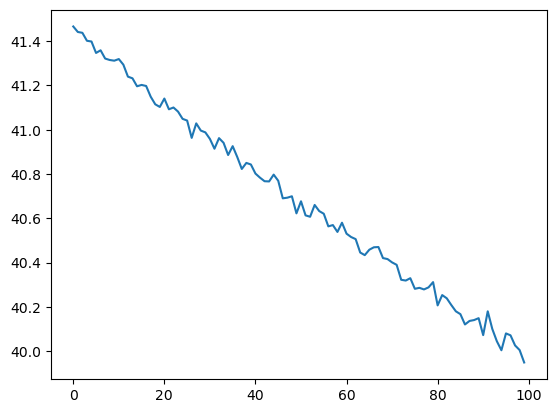

In [10]:
ot_cfm_model= train(params, n_times, X_phate, X_phate_conditional)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class ConditionalODEVectorField(nn.Module):
    def __init__(self, model, cond_dim, evolve_dim):
        super().__init__()
        self.model = model
        self.cond_dim = cond_dim
        self.evolve_dim = evolve_dim
        self.total_dim = cond_dim + evolve_dim

    # --- Add 'args=None' to the signature ---
    def forward(self, t, x, args=None):
        # x is the full state [gene_conditional, metabolic_input], shape [B, total_dim]
        # t is the current time
        # args is an optional argument passed by torchdyn (we can ignore it if unused)

        # 1. Prepare input for the underlying model
        if x.dim() > 1: # Handle batch dimension
             t_expanded = t.expand(x.shape[0], 1) if isinstance(t, torch.Tensor) else torch.full((x.shape[0], 1), t, device=x.device, dtype=x.dtype)
        else: # Handle single sample
             t_expanded = t.reshape(1, 1) if isinstance(t, torch.Tensor) else torch.tensor([[t]], device=x.device, dtype=x.dtype)

        model_input = torch.cat([x, t_expanded], dim=-1)

        # 2. Get the derivative for the evolving part
        d_evolve_dt = self.model(model_input)

        # 3. Create the zero derivative for the conditional part
        zeros_for_cond = torch.zeros_like(x[:, self.evolve_dim:self.total_dim])

        # 4. Concatenate
        full_derivative = torch.cat([d_evolve_dt, zeros_for_cond], dim=-1)

        # 5. Assert shapes
        assert full_derivative.shape == x.shape, \
            f"Output derivative shape {full_derivative.shape} must match input state shape {x.shape}"

        return full_derivative
    

class TorchWrapperWithConditional(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, t, args=None):
        # x is expected to have shape [batch_size, N+1]
        return self.model(x, t)

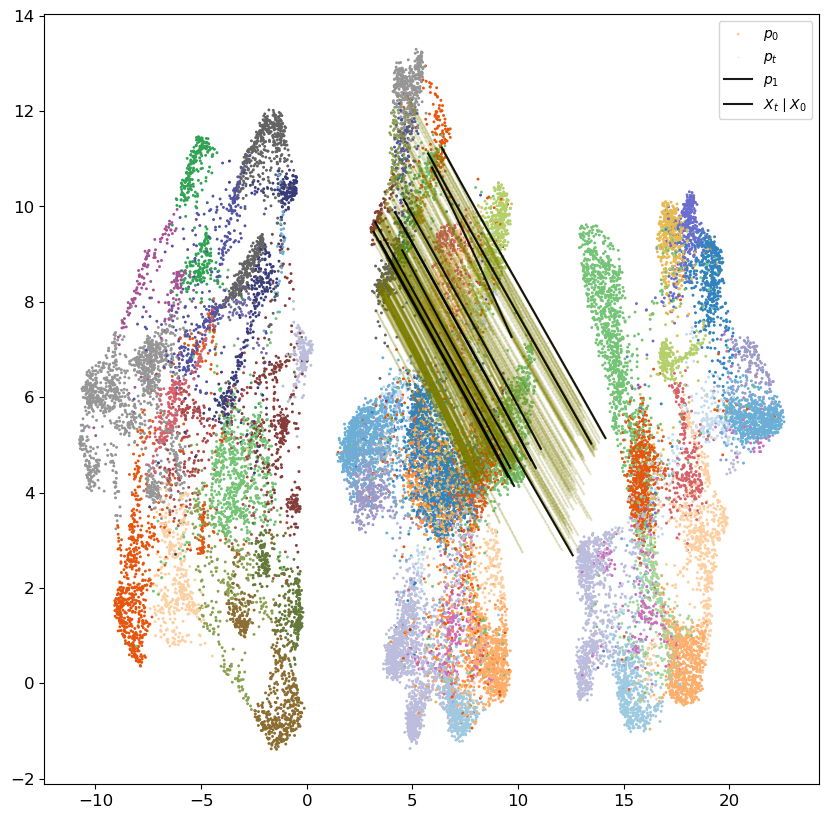

In [12]:
# node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
# with torch.no_grad():
#     traj = node.trajectory(
#         torch.from_numpy(X_raw[0][:1000]).float().to(device),
#         t_span=torch.linspace(0, n_times - 1, 400),
#     ).cpu()
#     # import pdb; pdb.set_trace()
#     # plot_trajectories(traj.cpu().numpy())
#     plot_trajectories_new(traj.cpu().numpy(), data_df)

# node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
# with torch.no_grad():
#     traj = node.trajectory(
#         torch.from_numpy(X_phate[0][:1000]).float().to(device),
#         t_span=torch.linspace(0, n_times - 1, 400),
#     ).cpu()
#     # import pdb; pdb.set_trace()
#     plot_trajectories(traj.cpu().numpy())
#     # plot_trajectories_new(traj.cpu().numpy(), data_df)

    
node = NeuralODE(ConditionalODEVectorField(ot_cfm_model, 1, 2), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.cat([torch.from_numpy(X_phate[0][:1000]).float().to(device), torch.from_numpy(X_phate_conditional[0][:1000][:, None]).float().to(device)], dim=-1),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    # import pdb; pdb.set_trace()
    plot_trajectories(traj.cpu().numpy(), day_list)
    # plot_trajectories_new(traj.cpu().numpy(), data_df)

In [14]:
scRNA.obs[cell_type_key].values

['Immature nptxEX', 'Immature nptxEX', 'VLMC', 'CP', 'Immature nptxEX', ..., 'VLMC', 'VLMC', 'VLMC', 'VLMC', 'VLMC']
Length: 28757
Categories (32, object): ['CMPN', 'CP', 'Immature CMPN', 'Immature DMIN', ..., 'sfrpEGC', 'sstIN', 'tlNBL', 'wntEGC']

In [26]:
(scRNA.obs[cell_type_key].values)

['Immature nptxEX', 'Immature nptxEX', 'VLMC', 'CP', 'Immature nptxEX', ..., 'VLMC', 'VLMC', 'VLMC', 'VLMC', 'VLMC']
Length: 28757
Categories (32, object): ['CMPN', 'CP', 'Immature CMPN', 'Immature DMIN', ..., 'sfrpEGC', 'sstIN', 'tlNBL', 'wntEGC']

In [27]:
type(scRNA.obs[cell_type_key].values)

pandas.core.arrays.categorical.Categorical

In [28]:
scRNA.obs[cell_type_key].values.categories

Index(['CMPN', 'CP', 'Immature CMPN', 'Immature DMIN', 'Immature MSN',
       'Immature cckIN', 'Immature dpEX', 'Immature mpEX', 'Immature nptxEX',
       'MCG', 'MSN', 'Unknown', 'VLMC', 'cckIN', 'dEGC', 'dNBL1', 'dNBL2',
       'dNBL3', 'dNBL4', 'dNBL5', 'dpEX', 'mpEX', 'mpIN', 'nptxEX', 'npyIN',
       'ntng1IN', 'ribEGC', 'scgnIN', 'sfrpEGC', 'sstIN', 'tlNBL', 'wntEGC'],
      dtype='object')

In [32]:
feasible_matrix= pd.read_csv('./datasets/metadata/cell_type_feasibility_matrix.csv', index_col=0)



In [33]:
a = ['Immature CMPN', 'Immature CMPN', 'Immature DMIN']
b = ['CMPN', 'dNBL5']

submatrix = feasible_matrix.loc[a, b]
bio_prior = np.where(submatrix.values, 0, -np.inf)
print(bio_prior)

[[  0. -inf]
 [  0. -inf]
 [-inf -inf]]
